This Notebook contains the analysis of the question :

**What is the ideal time frame between a book's publication and its film adaptation?**

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import re
import ast

# Part I

In [116]:
df = pd.read_csv("./data/book_adaptation.csv")
df

,movie_title,movie_release,movie_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,imdb_rating,imdb_total_votes,movie_budget,...,book_horror,book_thriller,book_detective,book_satire,book_comedy,book_won_price,book_pages,book_rating,book_total_ratings,movie_is_adaptation
0,Ghosts of Mars,2001.0,1.871706e+07,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,56933.0,3.740519e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",6.0,69.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Brun bitter,1988.0,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",5.6,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,White Of The Eye,1987.0,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",6.1,2899.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,A Woman in Flames,1983.0,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.9,623.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82012,Mermaids: The Body Found,2011.0,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",4.6,1711.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
82013,Knuckle,2011.0,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",6.8,3194.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
82014,Another Nice Mess,1972.0,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",5.8,112.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
82015,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",NaN,NaN,1.693816e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [117]:
time_frame_release = df[["movie_title", "movie_release", "book_release", "movie_is_adaptation", 'imdb_rating']]
time_frame_release = time_frame_release[time_frame_release["book_release"].notnull()]
time_frame_release = time_frame_release.drop(columns='movie_is_adaptation', axis=1).copy(deep=True)
time_frame_release = time_frame_release[time_frame_release['movie_release'].notnull()].copy(deep=True)
time_frame_release

,movie_title,movie_release,book_release,imdb_rating
43,Mysterious Island,1982.0,1959.0,5.4
44,Mysterious Island,1982.0,1957.0,5.4
96,The Thirteen Chairs,1969.0,1928.0,5.8
132,The Great Santini,1979.0,1976.0,7.2
135,Carmen,2003.0,1845.0,6.1
...,...,...,...,...
81913,Norwegian Wood,2010.0,1987.0,6.3
81937,The Four Feathers,1939.0,1902.0,7.4
81944,How to Eat Fried Worms,2006.0,1973.0,5.3
81961,Sherlock Holmes and the Voice of Terror,1942.0,1917.0,6.4


In [118]:
time_frame_release[["book_release","movie_release"]] = time_frame_release[["book_release", "movie_release"]].astype(int);

In [119]:
time_frame_release["time_frame"] = (time_frame_release['movie_release']-time_frame_release['book_release']).astype(int)

In [120]:
time_frame_release = time_frame_release.query('time_frame > 0')
time_frame_release

,movie_title,movie_release,book_release,imdb_rating,time_frame
43,Mysterious Island,1982,1959,5.4,23
44,Mysterious Island,1982,1957,5.4,25
96,The Thirteen Chairs,1969,1928,5.8,41
132,The Great Santini,1979,1976,7.2,3
135,Carmen,2003,1845,6.1,158
...,...,...,...,...,...
81913,Norwegian Wood,2010,1987,6.3,23
81937,The Four Feathers,1939,1902,7.4,37
81944,How to Eat Fried Worms,2006,1973,5.3,33
81961,Sherlock Holmes and the Voice of Terror,1942,1917,6.4,25


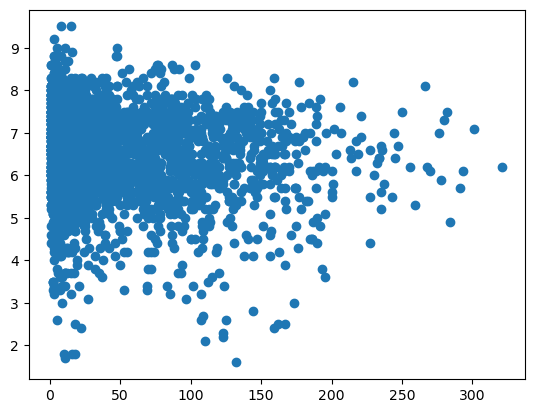

In [121]:
plt.scatter(x=time_frame_release['time_frame'], y=time_frame_release['imdb_rating']);

# Part II :

In [122]:
time_frame_criteria = 25
control = 